# Coastline Recession in Bangladesh: A Temporal Analysis
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/planetlabs/notebooks/blob/master/jupyter-notebooks/coastal-erosion-example/coastline_analysis.ipynb)

In this notebook, we will be analyzing a severe example of coastal erosion. To do so we will:
- Extract data from multi-band imagery
- Compute the normalized difference water index (NDWI)
- Use NDWI to identify which pixels are associated to water and which pixels are associated with land
- Use classical image processing and computer vision techniques to analyze coastal erosion within the area of interest (AOI)

We have provided you with data for your AOI, which has already been processed, mosaiced, and hosted.

This AOI and analysis has been inspired by a the following paper: Crawford, T.W. et al., Coastal Erosion and Human Perceptions of Revetment Protection in the Lower Meghna Estuary of Bangladesh. Remote Sens. 2020, 12, 3108. https://doi.org/10.3390/rs12183108

**For this tutorial, you will need to:**
- Download all of the data needed for this analysis. If you're running this in Colab, then the data will be easily accessed by running the first code cell. Otherwise, please download these data from the following link: 
https://github.com/planetlabs/notebooks/blob/master/jupyter-notebooks/coastal-erosion-example/0_download_data.ipynb
- Install and import the packages below

In [ ]:
#!wget -q -O tmp.zip https://hello.planet.com/data/s/Y2wFKNFNTwHxot8/download/coastal_erosion_workshop_data.zip && unzip tmp.zip && rm tmp.zip

In [ ]:
#!pip install rasterio

In [1]:
from glob import glob

import rasterio
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

%matplotlib inline

## Retrieve data
Within our data folder, labeled `coastal_erosion_workshop_data`, we have both Analytic Surface Reflectance images and Visual images. While these images reflect the same AOI, they are used for different purposes. The visual images are colour-corrected and intended to be viewed and analyzed by the human eye, while the analytical images are orthorectified, radiometrically-calibrated, and are stored as 16-bit scaled radiance, which are intended to be used for scientific purposes. You may find out more on our [Dev Center](https://developers.planet.com/docs/data/planetscope/#asset-types).

Let's retrieve both the multi-band and visual-band images across our entire time of interest (2017 - 2023), then sort the data to be chronological.

The AOI encapsulates a small, 7 km (4.4 mi) long, coastal region in Kamalnagar, Chittagong, Bangladesh, which is located in Southern Bangladesh, where the ocean (Bay of Bengal) meets a major inlet, the Meghna River. We have chosen to image the AOI once each spring to analyze.

Coastal erosion in Bangladesh is a recurring problem, causing thousands of people to be displaced annually. In fact, coastal Bangladesh experiences erosion rates that are among the highest in the world.

<img src="assets/region.png" height=600 />

Let's import the analytic and visual data!
 
Please note that this method below only works for Linux and Unix operating systems (i.e., Ubuntu, MacOS, etc.), however if you're running this on Colab, this will work just fine.

In [32]:
# The base directory which holds all of the imagery
# data_directory = "coastal_erosion_workshop_data"
# REMOVE
data_directory = "/Users/kevin.lacaille/Documents/Projects/Conferences/2023/PyCon2023/coastal_erosion_workshop_data/"

# Find all relevant files
analytic_filenames = glob(data_directory + "/*analytic/composite.tif")
visual_filenames = glob(data_directory + "/*visual/composite.tif")

# Sort the file chronologically, from 2017 to 2023
analytic_filenames.sort()
visual_filenames.sort()

# REMOVE
[print(filename) for filename in analytic_filenames]
[print(filename) for filename in visual_filenames]

/Users/kevin.lacaille/Documents/Projects/Conferences/2023/PyCon2023/coastal_erosion_workshop_data/2017_analytic/composite.tif
/Users/kevin.lacaille/Documents/Projects/Conferences/2023/PyCon2023/coastal_erosion_workshop_data/2018_analytic/composite.tif
/Users/kevin.lacaille/Documents/Projects/Conferences/2023/PyCon2023/coastal_erosion_workshop_data/2019_analytic/composite.tif
/Users/kevin.lacaille/Documents/Projects/Conferences/2023/PyCon2023/coastal_erosion_workshop_data/2020_analytic/composite.tif
/Users/kevin.lacaille/Documents/Projects/Conferences/2023/PyCon2023/coastal_erosion_workshop_data/2021_analytic/composite.tif
/Users/kevin.lacaille/Documents/Projects/Conferences/2023/PyCon2023/coastal_erosion_workshop_data/2022_analytic/composite.tif
/Users/kevin.lacaille/Documents/Projects/Conferences/2023/PyCon2023/coastal_erosion_workshop_data/2023_analytic/composite.tif
/Users/kevin.lacaille/Documents/Projects/Conferences/2023/PyCon2023/coastal_erosion_workshop_data/2017_visual/composit

[None, None, None, None, None, None, None]

Now, we're going to create an image processing pipeline! For simplicity, we will wrap each method into individual functions.

## Extract spectral bands
Create a function to extract spectral bands from a PlanetScope 4-band imagery.
These spectral bands will be used later to compute the normalized difference water index (NDWI), which will be used to find which pixels are associated with water and which are associated with land.

In [12]:
def extract_spectral_bands(image_filename):
    """
    Extracts green and NIR bands from a PlanetScope 4-band imagery.

    Parameters:
    -----------
        image_filename : str
                     The path to a PlanetScope 4-Band image.
    
    Returns:
    --------
        green : Array[int]
                     Green band image.
        nir :   Array[int]
                     NIR band image.
    """

    # Extract the green and NIR bands
    with rasterio.open(image_filename) as src:
        green = src.read(2)
        nir = src.read(4)

    return green, nir

Let's take a look at how this function works for the second data point in our time series, in 2018. Since we've sorted our analytic and visual filenames, the 2018 image will be the second image (n = 1).

In [41]:
# Let's take our 2018 data as an example (second image in our dataset)
n = -1
# Extract the green and NIR bands from 2018's 4-band analytic image
green, nir = extract_spectral_bands(analytic_filenames[n])

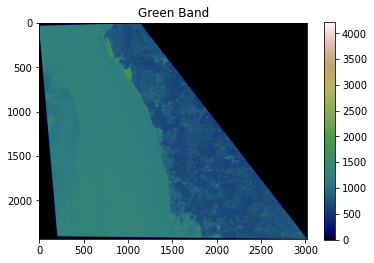

In [42]:
# Plot the green band using a non-default colour map & a colour bar
# see also: https://matplotlib.org/stable/tutorials/colors/colormaps.html
fig = plt.imshow(green)
fig.set_cmap('gist_earth')
plt.colorbar()
plt.title("Green Band")

# Display the results.
plt.show()

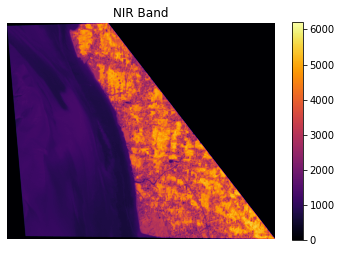

In [43]:
# Plot the red band
fig = plt.imshow(nir)
fig.set_cmap('inferno')
plt.colorbar()
plt.title("NIR Band")

# Since the axis labels are useless here, let's turn them off.
plt.axis('off')

# Display the results.
plt.show()

## Compose scene using visual imagery
Create a function to compose a scene, given red, green, and blue bands from PlanetScope Visual products.

In [14]:
def compose_scene(image_filename):
    """
    Extracts red, green, and blue bands from a PlanetScope Visual product and
    stacks them to compose a scene.

    Parameters:
    -----------
        image_filename : str
                     The path to a PlanetScope 4-Band image.
    
    Returns:
    --------
        red :   Array[int]
                     Red band image.
        green : Array[int]
                     Green band image.
        blue :  Array[int]
                     Blue band image.
    """

    # Extract visual imagery
    with rasterio.open(image_filename) as src:
        blue = src.read(1)
        green = src.read(2)
        red = src.read(3)

    # Stack the 3 bands to create an RGB visual image
    visual_image = np.dstack((blue, green, red))

    return visual_image

Let's see what the AOI looks like with Visual product imagery.

In [44]:
# Extract visual images
visual_image = compose_scene(visual_filenames[n])

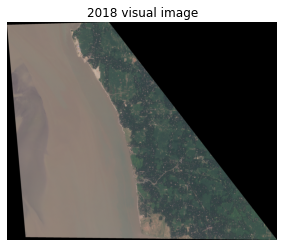

In [45]:
plt.imshow(visual_image)
plt.axis('off')
plt.title("2018 visual image")
plt.show()

## Compute the Normalized Difference Water Index (NDWI)
This function will measure the
[normalized difference water index](https://en.wikipedia.org/wiki/Normalized_difference_water_index) (NDWI), 
defined as: $NDWI = (green - NIR) / (green + NIR)$.

Please note that this requires that both the green and NIR imagery are normalized, which has already been done in the data processing pipeline for the Analytic Surface Reflectance data we're using.

In [36]:
def measure_ndwi(green, nir):
    """
    Computes the normalized difference water index (NDWI).

    Parameters:
    -----------
        green : Array[int]
               Normalized green band image.
        nir : Array[int]
               Normalized NIR band image.
    
    Returns:
    --------
        ndwi : Array[float]
               Normalized difference water index.    
    """

    # Allow division by zero
    np.seterr(divide='ignore', invalid='ignore')

    # Calculate NDWI
    ndwi = (green.astype(float) - nir.astype(float)) / (green + nir)

    return ndwi

Now, let's use our analytic imagery to compute the NDWI, which will help us determine which pixels are associated with water and which are associated with land.

In [46]:
# Compute NDWI
ndwi = measure_ndwi(green, nir)

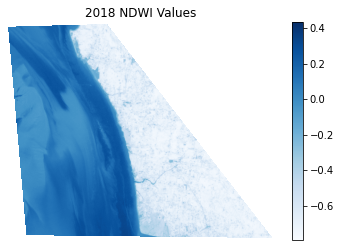

In [47]:
fig = plt.imshow(ndwi)
fig.set_cmap('Blues')
plt.axis('off')
plt.colorbar()
plt.title("2018 NDWI Values")
plt.show()

Notice how the strip of coastline on the right side of the AOI has relatively low NDWI values and the water on the left has relatively high NDWI values?

## Find water and land pixels
NDWI values range from -1 to +1. Pixels which have a relatively high NDWI value (NDWI >= 0.3) are likely to be
associated with water, whereas pixels with values under this threshold 
(NDWI < 0.3) are unlikely to be associated with water.

In [24]:
def find_water_and_land(ndwi):
    """
    Given an NDWI image, return a mask with pixels associated with water and
    another mask with pixels associated with land.

    Parameters:
    -----------
        ndwi : Array[float]
               Normalized difference water index.
    
    Returns:
    --------
        water_mask : Array[int]
               A binary mask for water.
        land_mask :  Array[int]
               A binary mask for land.
    """

    # Although the water threshold is NDWI >= 0.3
    # we'll set it lower to account of murky waters
    WATER_THRESHOLD = 0.0

    # Create arrays of NANs
    water_mask = np.full(ndwi.shape, np.nan)
    land_mask = np.full(ndwi.shape, np.nan)

    # Threshold the NDWI image and create water & land masks
    water_mask[ndwi >= WATER_THRESHOLD] = 1
    land_mask[ndwi < WATER_THRESHOLD] = 1

    return water_mask, land_mask

Now, let's take a look at the masks we created. Our `find_water_and_land()` function returns two arrays, `water_mask` and `land_mask`, both only containing 0s and 1s, where 1s indicate a positive association and 0s indicate a negative association. For instance, in the `water_mask` array, all pixels that have a value of 1 are associated with water and all pixels with a value of 0 are not. Let's take a moment to visualize our land mask as a `numpy` array. Note: NANs represent regions of the maps that have been clipped.

In [48]:
# Create water and land masks from the NDWI array
water_mask, land_mask = find_water_and_land(ndwi)
print(land_mask)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ...  1.  1.  1.]
 [nan nan nan ...  1.  1.  1.]
 [nan nan nan ...  1.  1.  1.]]


Now, let's visualize these water and land mask arrays as maps!

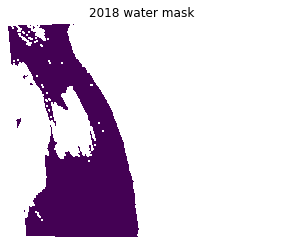

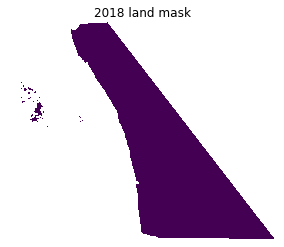

In [49]:
plt.figure(0)
plt.imshow(water_mask)
plt.axis('off')
plt.title("2018 water mask")
plt.show()

plt.figure(1)
plt.imshow(land_mask)
plt.axis('off')
plt.title("2018 land mask")
plt.show()

These masks correlate quite closely with where water and land actually exist, however notice how we see holes in the water and land masks? In the water mask, it is likely due to the fact that we are imaging especially murky water with either excessive vegetation growth, or perhaps these pixels are associated with sandbars off of the coast! For the land mask, we are likely picking up small bodies of water inland.
 
For our coastline analysis, we only care about where the water meets the land, so it would be most helpful for us to have clean distinctions between what is "mostly land" to what is "mostly water”. Specifically, we want to create a mask for the ocean and a mask for the land. We can do this by applying morphological filters to clean up our pixel classification.

## Apply Filters
We can apply [morphological filters](https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html)
to filter out the unwanted pixels in the water and land masks.
We use a closing filter to close small clusters of pixels (e.g., holes) inside parts of a mask.
Following, we use an opening filter to remove any small clusters of pixels outside a mask.

In [28]:
def filter_mask(closing_kernel_size, opening_kernel_size, mask):
    """
    Given a mask, apply morphological filters (closing followed by opening) 
    to filter out unwanted pixels.

    Parameters:
    -----------
       closing_kernel_size : Int
                             Size of the closing kernel in pixels.
       opening_kernel_size : Int
                             Size of the opening kernel in pixels.
        mask : Array[int]
               A binary mask.
    
    Returns:
    --------
        mask_closed_opened : Array[int]
               A morphologically filtered binary mask.
    """

    ## Closing filter: Remove empty pixels within mask
    # Create a kernel element which is closing_kernel_size^2 in size
    closing_kernel_element = (closing_kernel_size, closing_kernel_size)
    # Create a closing filter kernel
    closing_kernel = cv2.getStructuringElement(cv2.MORPH_RECT,
                                               closing_kernel_element)
    # Apply closing filter to input mask
    mask_closed = cv2.morphologyEx(np.nan_to_num(mask), cv2.MORPH_CLOSE,
                                   closing_kernel)

    ## Opening filter: Removing filled pixels outside of mask
    # Create a kernel element which is closing_kernel_size^2 in size
    opening_kernel_element = (opening_kernel_size, opening_kernel_size)
    # Create an opening filter kernel
    opening_kernel = cv2.getStructuringElement(cv2.MORPH_RECT,
                                               opening_kernel_element)
    # Apply opening filter to closed mask
    mask_closed_opened = cv2.morphologyEx(mask_closed, cv2.MORPH_OPEN,
                                          opening_kernel)

    # Ensure the clipped areas remain clipped
    mask_closed_opened[mask_closed_opened == 0] = np.nan

    return mask_closed_opened

Let's see how this works in practice. Let's apply these morphological filters to both the water and land masks. These kernel sizes were chosen by empirical observations. To put them in physical units, multiply them by the pixel size (~3.7m / px).

In [63]:
# Filter the water mask
CLOSING_KERNEL_SIZE = 29
OPENING_KERNEL_SIZE = 13
water_mask_filtered = filter_mask(CLOSING_KERNEL_SIZE, OPENING_KERNEL_SIZE,
                                  water_mask)

# Filter the land mask
CLOSING_KERNEL_SIZE = 3
OPENING_KERNEL_SIZE = 101
land_mask_filtered = filter_mask(CLOSING_KERNEL_SIZE, OPENING_KERNEL_SIZE,
                                 land_mask)

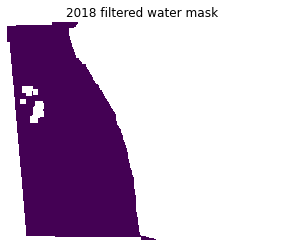

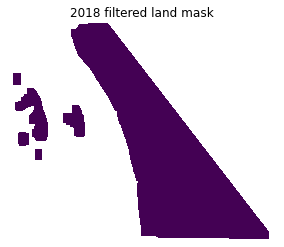

In [64]:
plt.figure(0)
plt.imshow(water_mask_filtered)
plt.axis('off')
plt.title("2018 filtered water mask")
plt.show()

plt.figure(1)
plt.imshow(land_mask_filtered)
plt.axis('off')
plt.title("2018 filtered land mask")
plt.show()

Viola! Now we have clear distinctions between land and water without any pesky pixels to distract us!

Now, we can implement this entire process we just walked through, to each of the images over the time series, from 2017 to 2023.
 
Below we've created an image processing pipeline, which will loop through each of the functions we created above, which will extract processed water and land masks for each date in our time series, from 2017 to 2023. At the end of the loop we store the filtered land mask in a list for further analysis.

In [31]:
# Define the number of years in the time series
NUM_YEARS = 2023 - 2017 + 1
# Create an empty list to append data
all_land_masks = []

# Process data for each year
for n in range(NUM_YEARS):
    # Extract green, red, and NIR data from 4-Band imagery
    green, nir = extract_spectral_bands(analytic_filenames[n])
    # Extract visual images
    visual_image = compose_scene(visual_filenames[n])
    # Compute NDWI
    ndwi = measure_ndwi(green, nir)
    # Create water and land masks
    water_mask, land_mask = find_water_and_land(ndwi)
    # Filter masks to fill out space
    water_mask_filtered = filter_mask(29, 13, water_mask)
    land_mask_filtered = filter_mask(3, 101, land_mask)
    # Append land mask to a list for further analysis
    all_land_masks.append(land_mask_filtered)

## Analyze Results 

Now that we have our NDWI thresholds and water and land masks for each date in our time series, we can begin interpreting the year-over-year changes.

Let's first look at landmass lost by measuring the physical area of land lost over time. To do this, first we'll simply take the difference between the land mask for the last image (2023) and the first image (2017), which will leave us with a new mask, which shows all land lost in our time series. Then, we'll count the number of pixels remaining, then multiply the number of pixels by the area of each pixel, which is 3.7m x 3.7m = 13.7 meters squared. For more information on PlanetScope resolution, check out our [Dev Center](https://developers.planet.com/docs/data/planetscope/)!

### Landmass Loss

In [ ]:
# The difference between the 2017 and the 2023 land masks
# Using nan_to_num function to set all NANs to zero, as to not blow up the code
land_difference = np.nan_to_num(all_land_masks[0]) - np.nan_to_num(
    all_land_masks[-1])

# resolution in m
resolution = 3.7
# area per pixel in m^2
area_per_pixel = resolution**2

In [ ]:
print(
    f"Total landmass lost: {round(np.nansum(land_difference) * area_per_pixel * 1e-6)} km^2 over the past {NUM_YEARS} years"
)

Let's visualize the total landmass lost over our time series.

In [ ]:
# Total Landmass Lost
plt.imshow(land_difference)
plt.colorbar()
plt.axis('off')
plt.title("Cumulative landmass lost from 2017 to 2023")
plt.show()

Now, let's compute and visualize the amount of land lost over the time series.

In [ ]:
# A time array for the time series
time = np.arange(NUM_YEARS)

# Compute the difference between the landmass of 2017 to each year
landmass_loss = np.nansum(all_land_masks[0]) - list(
    map(np.nansum, all_land_masks))

In [ ]:
# Cumulative Landmass Lost
plt.plot(time, landmass_loss * 1e-3, 'o-')
plt.title("Total Landmass lost over 6 years")
plt.xlabel("Years since 2017")
plt.ylabel(r"Area lost (1000 m$^2$)")
plt.show()

The landmass lost over the past 6 years is increasing rather quickly!

But how quickly is the coastal region losing land? Let's compute the velocity of landmass lost by measuring the change of land mass over the change of time, i.e. $v(t) = \Delta M / \Delta t$

In [ ]:
# Compute the velocity of landmass lost
landmass_loss_velocity = np.diff(landmass_loss) / np.diff(time)

In [ ]:
# Velocity of Landmass Lost
plt.plot(time[1:], landmass_loss_velocity * 1e-3, 'o-')
plt.title("Landmass lost over 6 years is speeding up")
plt.xlabel("Years since 2017")
plt.ylabel(r"Speed of area lost per year (1000 m$^2$ / yr)")
plt.show()

The landmass lost doesn't appear to be happening at a constant rate - it appears to be speeding up!

Let's find out how quickly the speed of landmass lost is speeding up by measuring its acceleration, i.e. $a(t) = \Delta v / \Delta t$

In [ ]:
# Compute the acceleration of landmass lost
landmass_loss_acceleration = np.diff(landmass_loss_velocity) / np.diff(
    time[1:])

In [ ]:
# We see that our landmass loss over the past 6 years is accelerating
plt.plot(time[2:], landmass_loss_acceleration * 1e-3, 'o-')
plt.title("Rate of landmass lost over 6 years is accelerating")
plt.xlabel("Years since 2017")
plt.ylabel(r"Acceleration of area lost per year (1000 m$^2$ / yr$^2$)")
plt.show()

The speed at which this area is losing landmass is accelerating year after year, which means the problem is getting worse!

### Land Recession

Going one step further, we can measure coastline erosion through land recession, in other words, we can measure how much the coastline has receded inland. One way to do this is to find the coastline in 2017 and 2023, then measure the distance between the two coasts. We can do this by looking at the `land_difference` array and using an edge detection algorithm to find the coastlines in 2017 and in 2023.
 
Specifically, we'll employ a computer vision algorithm called "Canny Edge Detection" to detect the edge of the landmass at the beginning and end of our time series, then measure the distance between the two coasts.
 
You can learn more about edge detection method we are using here: https://learnopencv.com/edge-detection-using-opencv/

In [ ]:
# Detect the edges of the cumulative land loss map
edges_all = cv2.Canny(image=np.uint8(land_difference),
                      threshold1=0,
                      threshold2=1)

The figure below shows the canny edge detection's output.

In [ ]:
plt.imshow(edges_all, vmin=0, vmax=1)
plt.axis('off')
plt.title("Canny Edge Detection")
plt.show()

Finally, we can create an automated search for the 2017 coastline (on the left) and the 2023 coastline (on the right). We'll do this by creating a histogram of all of the coastal pixels, by binning up all of the pixels from left to right, vertically.

In [ ]:
# Bin up all edge pixels, vertically
_, xpos = np.where(edges_all > 0)
NUM_BINS = 12
N, x = np.histogram(xpos, bins=NUM_BINS)
bin_width = x[1] - x[0]

Now, we can identify the peaks of the histogram and use those to roughly identify where the 2017 and 2023 coastlines are.

In [ ]:
# Find the peaks of the histogram -> these are the coastline edges
coastlines = x[find_peaks(N)[0]]
coastline_2017 = coastlines[0]
coastline_2023 = coastlines[1]

Let's quickly visualize the resulting histogram and the associated peaks.

In [ ]:
plt.hist(xpos, bins=NUM_BINS, alpha=0.5)
plt.axvline(x=coastline_2017 + bin_width / 2, color='k', ls='--')
plt.axvline(x=coastline_2023 + bin_width / 2, color='k', ls='--')

Below is the output from the canny edge detection with the histogram overlaid and with its peaks identified with black dashed lines. These peaks very closely correlate to where the coastlines actually exist.

In [ ]:
plt.imshow(edges_all, vmin=0, vmax=1)
plt.hist(xpos, bins=NUM_BINS, alpha=0.5)
plt.axvline(x=coastline_2017 + bin_width / 2, color='k', ls='--')
plt.axvline(x=coastline_2023 + bin_width / 2, color='k', ls='--')
plt.title("Canny Edge Detection (used for coast line detection)")
plt.show()

Now we have a rough estimate as to where our 2017 and 2023 coasts reside! However, we should note that this method only works if the coasts are vertically-aligned to the frame of reference.

Lastly, let's compute how much the coast has receded inland by taking the difference between the two coastline positions and multiplying them by the number of meters per pixels (~3.7 m/px).

In [ ]:
recession = (coastline_2023 - coastline_2017) * resolution

print(f"Land has receded {round(recession)} meters in {NUM_YEARS} years")
print(
    f"Land has receded {round(recession / NUM_YEARS)} meters/yr over the past {NUM_YEARS} years"
)